In [1]:
library("caret")
library("magrittr")
library("dplyr")
library("tidyr")
library("lmtest")
library("popbio")
library("e1071")

Loading required package: ggplot2

Loading required package: lattice


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:magrittr’:

    extract


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘popbio’


The following object is masked from ‘package:caret’:

    sensitivity




In [2]:
install.packages("readr")
install.packages("readxl")
library (readr)
library (readxl)


The downloaded binary packages are in
	/var/folders/b6/tn8p_f9d1ls_4qs2b7h32md00000gn/T//RtmplbfDbm/downloaded_packages

The downloaded binary packages are in
	/var/folders/b6/tn8p_f9d1ls_4qs2b7h32md00000gn/T//RtmplbfDbm/downloaded_packages


In [3]:
minerals <- read_csv("/Users/christinasimbenga/Desktop/minerals.csv")
head(minerals)

Rows: 64 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): Antimony, Gold

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Antimony,Gold
<dbl>,<dbl>
3.08,1
6.15,1
2.35,1
0.30,0
0.30,0
9.62,1


# Testing Assumptions

## Running the Base Logistic Model

In [4]:
mylogit <- glm(Gold ~ Antimony, data=minerals, family="binomial")

## Making the prediction 

In [5]:
probabilities <- predict(mylogit, type = "response")

In [6]:
minerals$Predicted <- ifelse(probabilities > .5, "pos", "neg")

In [7]:
minerals$PredictedR <- NA
minerals$PredictedR[minerals$Predicted=='pos'] <- 1
minerals$PredictedR[minerals$Predicted=='neg'] <- 0

In [8]:
minerals$PredictedR <- as.factor(minerals$PredictedR)
minerals$Gold <- as.factor(minerals$Gold)

## Creating a confusion matrix 

In [9]:
conf_mat <- caret::confusionMatrix(minerals$PredictedR, minerals$Gold)
conf_mat

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 34  8
         1  2 20
                                          
               Accuracy : 0.8438          
                 95% CI : (0.7314, 0.9224)
    No Information Rate : 0.5625          
    P-Value [Acc > NIR] : 1.615e-06       
                                          
                  Kappa : 0.6748          
                                          
 Mcnemar's Test P-Value : 0.1138          
                                          
            Sensitivity : 0.9444          
            Specificity : 0.7143          
         Pos Pred Value : 0.8095          
         Neg Pred Value : 0.9091          
             Prevalence : 0.5625          
         Detection Rate : 0.5312          
   Detection Prevalence : 0.6562          
      Balanced Accuracy : 0.8294          
                                          
       'Positive' Class : 0               
                                    

#34 cases where we predicted there will be no gold and there really wasnt. 2 cases where we predicted there would gold but there was actually no gold this is below 5 meaning we did not meet minimum sample size for binary logistic regression. 8 cases where we predicted there will be no gold, but there was actually gold. 20 cases where we predicted there will be gold and there was! 84% accurracy in our prediction being correct! 

# Logit Linearity

In [10]:
minerals1 <- minerals %>% 
dplyr::select_if(is.numeric)

In [11]:
predictors <- colnames(minerals1)

In [12]:
minerals1 <- minerals1 %>%
mutate(logit=log(probabilities/(1-probabilities))) %>%
gather(key= "predictors", value="predictor.value", -logit)

`geom_smooth()` using formula 'y ~ x'



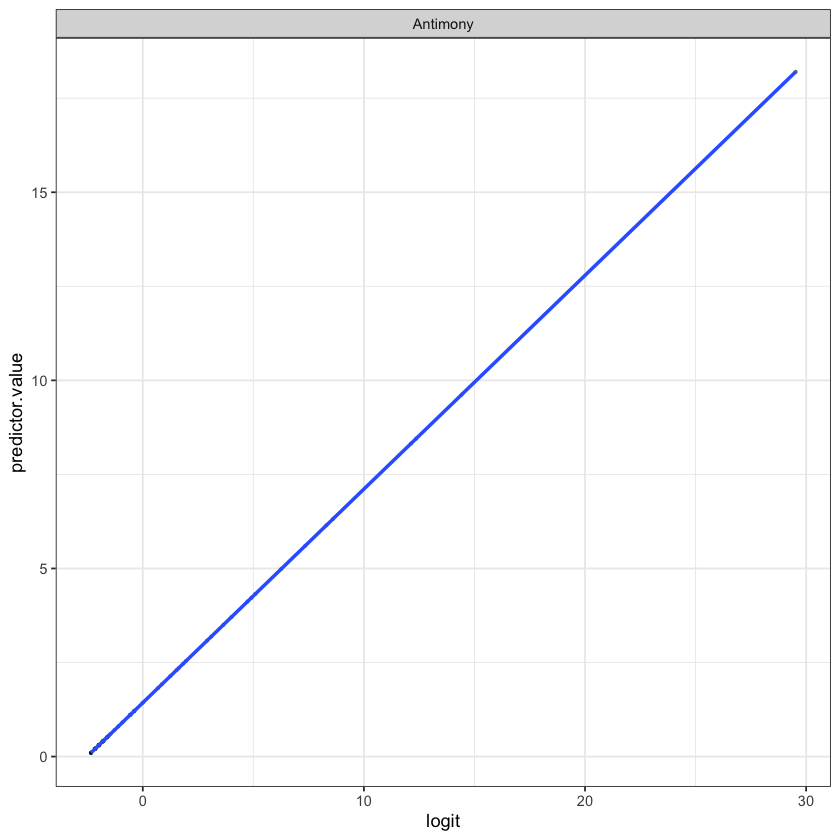

In [13]:
ggplot(minerals1, aes(logit, predictor.value))+
geom_point(size=.5, alpha=.5)+
geom_smooth(method= "loess")+
theme_bw()+
facet_wrap(~predictors, scales="free_y")

It is very much linear :-)

# Graphing the Errors

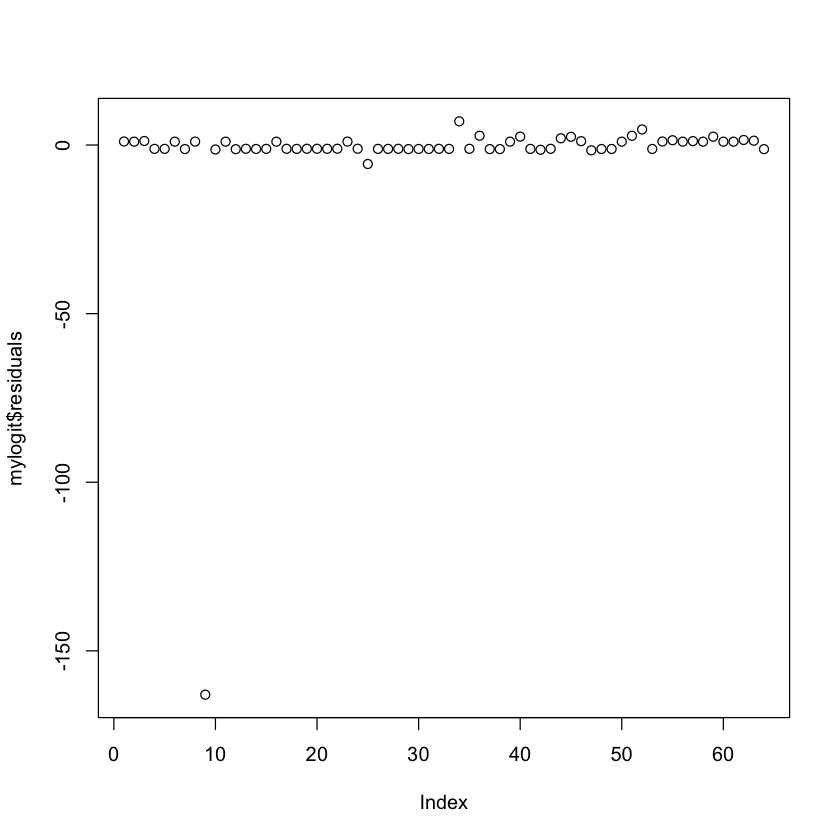

In [14]:
plot(mylogit$residuals)

pretty even distribution of points all the way across the x axis with some points sticking out. Pretty sure we have met the assumption of independent error 

## Using The Durbin-Watson Test 

In [15]:
dwtest(mylogit, alternative="two.sided")


	Durbin-Watson test

data:  mylogit
DW = 1.7616, p-value = 0.3316
alternative hypothesis: true autocorrelation is not 0


the test shows the pvalue is not statistically significant as it is (> .05), so we have independent errors.

# Screening for Outliers

In [16]:
infl <- influence.measures(mylogit)
summary(infl)

Potentially influential observations of
	 glm(formula = Gold ~ Antimony, family = "binomial", data = minerals) :

   dfb.1_ dfb.Antm dffit   cov.r   cook.d  hat  
3  -0.08   0.20     0.22    1.11_*  0.01    0.08
9   0.35  -0.55    -0.57_*  0.63_*  1.46_*  0.02
25  0.26  -0.62    -0.72_*  0.95    0.23    0.08
34  0.38  -0.22     0.39    0.88_*  0.08    0.03
46 -0.08   0.17     0.19    1.11_*  0.01    0.08
57 -0.08   0.18     0.20    1.11_*  0.01    0.08
63 -0.08   0.22     0.26    1.10_*  0.01    0.08


 dfb.1_ or dffit values are not greater than 1 and hat is not greater than .3 meaning theres no outlier that would need to be examined and removed

In [17]:
summary(mylogit)


Call:
glm(formula = Gold ~ Antimony, family = "binomial", data = minerals)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1918  -0.5462  -0.4471   0.2447   1.9748  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -2.5184     0.5958  -4.227 2.37e-05 ***
Antimony      1.7606     0.4883   3.606 0.000311 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 87.720  on 63  degrees of freedom
Residual deviance: 45.332  on 62  degrees of freedom
AIC: 49.332

Number of Fisher Scoring iterations: 7


 p value is significant at p < .001, which means that the number of Antimony is a significant predictor the number of times theres gold or not. 

Thank you :)